### Overview

We implement a simple quantum machine learning model that utilizes Quanvolutional Network idea introduced in "Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits by Henderson et al. [1].

[1] - https://arxiv.org/abs/1904.04767

Here we are following the tutorial on [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution/)


### Classical Convolution

Convolutional neural network or CNN is a widely used model in classical machine learning. The idea is to apply a function over a smaller region of the input data and _scan_ over the entire input to capture features while retaining spatial relations. It is worth noting that in case of a fully connected network, unlike a CNN, for the most part we miss that spatial relationship.

For an image input, the result of the convolution kernel is combined to produce an image like object which gets passed onto the next layer for further processing, in case of a typical NN (Neural Network) architecture.

### Quantum Convolution

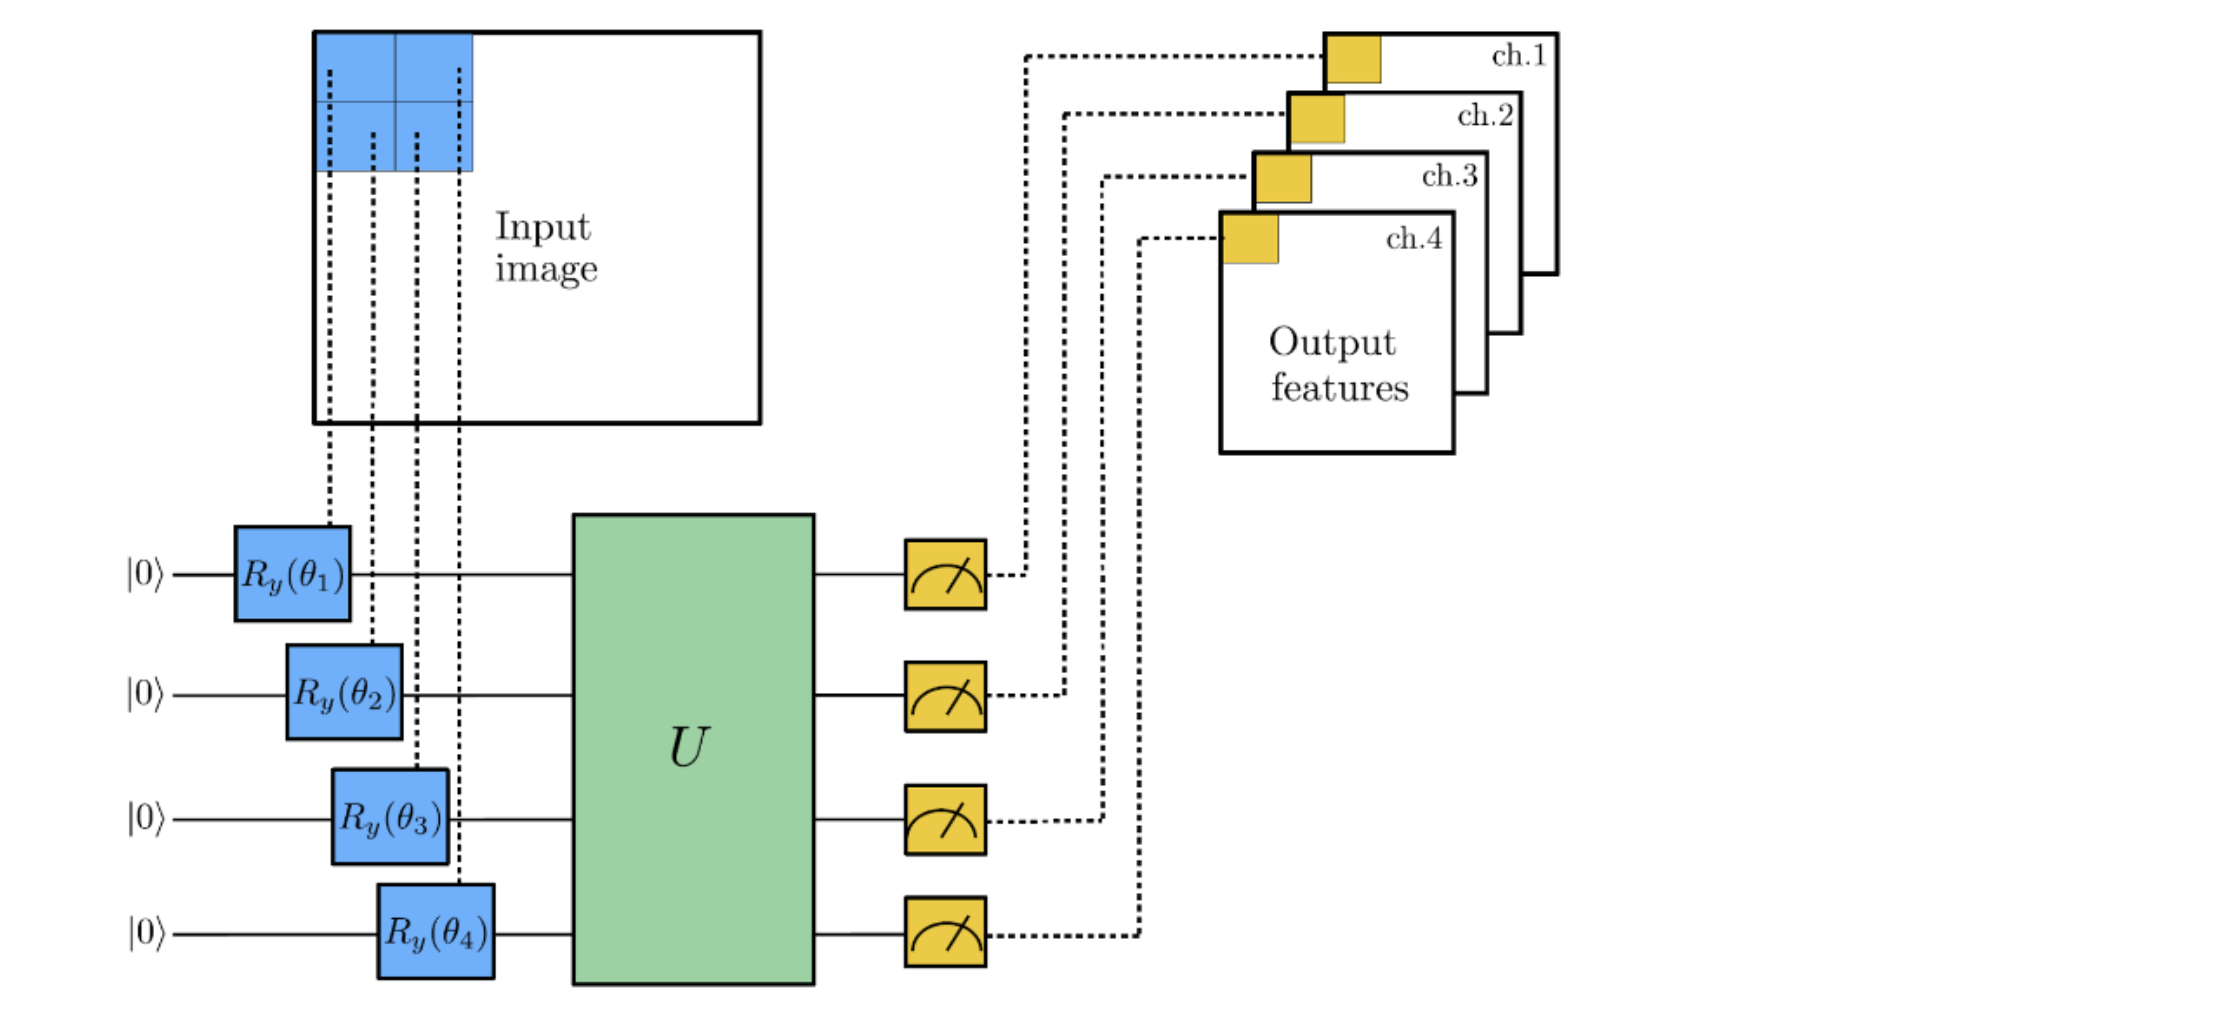

As shown above, we utilize a quantum circuit to generate complex kernels for a small function, keeping it tractable on classical system. We use parameterized rotations to capture the input data for a small region of the input image (2x2 in this example) and apply an unitary $U$, which for simplicity we use a random circuit.

After applying the quantum circuit we measure all the expectation values, which is treated as a mapped data to a different channel of the input pixel(s). Iterating ove the entire image, thus another imagelike object is created.

The above output can be post processed by additional layers, but in this simple example we use these raw expectation values and feed them directly into a classical network.

### Imports

We import a few modules necessarey for the following code blocks.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Hyperparameters

In a regula NN (Neural Network) setup, we are able to tune a lot of hyper-parameters. We declare these here, however we are varying them in this example.

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"
np.random.seed(101)
tf.random.set_seed(101)

### MNIST Dataset

We use the MNIST dataset from `keras`. For our test case we use a subset of the data.

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


### QC as kernel

As discussed above we create a small quantum circuit. We created a a device simulating 4 qubits. The input data is scaled by $\pi$ and we use $R_y$ rotations. A random circuit of `n_layers` is added. Finally, we measure all the expectation values (4 in this case).

In [5]:
dev = qml.device("default.qubit", wires=4)

np.random.seed(0)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

print("rand_params:", rand_params)

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


rand_params: [[3.44829694 4.49366732 3.78727399 3.42360201]]


The next function does the following.
* Divide the input images into 2x2 squares
* Scan the entire image using one 2x2 square at a time
* Return the 4 channel mapped values
The above process effectively halves the image resolution. Even though we take a 2x2 input and turn it into 2x2 output, we are effectively taking a stride of 2 pixels at a time.

In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


### Pre-processing data

We are not trying to train the quantum circuit for this exercise, we only apply it our input data / images. 

* We skip this pre-processing if we have already done so (we can always redo this by setting the `skip_preprocess` flag to `False` or deleting the pre-processed files. This way we won't need have to manually edit any flag to indicate process or not.
* In the later part we use these images as well un-modified set to compare and contrast.

In [9]:
import os

if os.path.exists(SAVE_PATH + "q_train_images.npy"):
    skip_preprocess = True
else:
    skip_preprocess = False

In [10]:
if skip_preprocess:
    print("Skipping data pre-processing")
else:
    os.makedirs(SAVE_PATH)
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Skipping data pre-processing


### Visualize pre-process effect

Let's take a look at the effect of the pre-processing done by the quantum circuit.

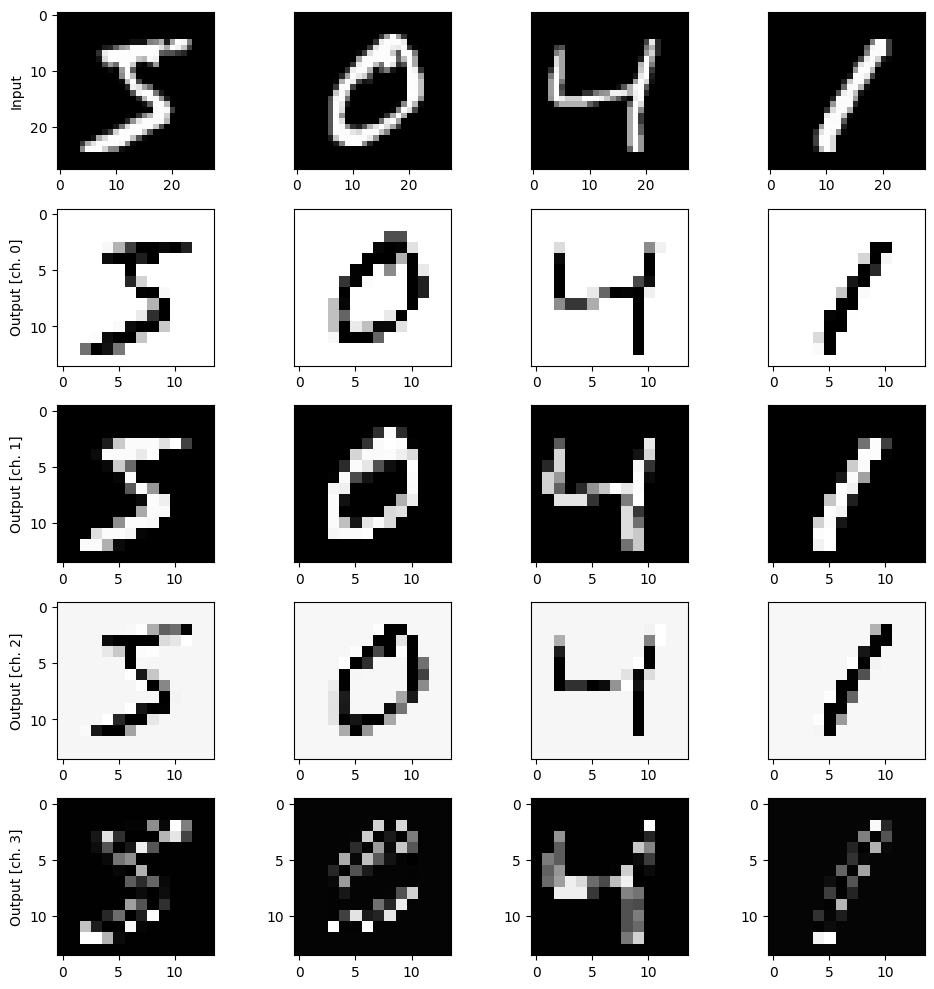

In [11]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


### Hybrid Model
We take the output of the quantum convolution layer created earlier and feed it to a classical NN and train it for the MNIST classes.

Our model simply consists of a fully connected layer with 10 outputs (for 10 classes, since we are classifying digits) with a softmax activation function. We use SGD (stochastic gradient descent) function with cross entropy for loss calculation.


In [12]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


### Training

Let's train a network with our pre-processed data with the quantum circuit.

In [40]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 42ms/step - accuracy: 0.1200 - loss: 2.7771 - val_accuracy: 0.3667 - val_loss: 1.9859
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.3200 - loss: 1.9347 - val_accuracy: 0.4333 - val_loss: 1.8190
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5600 - loss: 1.6006 - val_accuracy: 0.5000 - val_loss: 1.6828
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.3153 - val_accuracy: 0.5333 - val_loss: 1.5418
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 1.0874 - val_accuracy: 0.6000 - val_loss: 1.4542
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.8800 - loss: 0.9043 - val_accuracy: 0.6000 - val_loss: 1.3834
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 0.7607 - val_accuracy: 0.6333 - val_loss: 1.3211
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.6460 - val_accuracy: 0.6667 - val_loss: 1.2699
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.5531 - val_accuracy: 0.6667 - val_loss: 1.2291
Epoch 10/30
13/13 

### Baseline to compare
We train another model with the unmodified MNIST data (no quantum circuit based pre-processing).


In [41]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 0s - 38ms/step - accuracy: 0.0800 - loss: 2.4540 - val_accuracy: 0.0667 - val_loss: 2.4904
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.2800 - loss: 2.0622 - val_accuracy: 0.1333 - val_loss: 2.3202
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.5400 - loss: 1.7762 - val_accuracy: 0.2667 - val_loss: 2.1619
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.6400 - loss: 1.5323 - val_accuracy: 0.3333 - val_loss: 2.0202
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.7200 - loss: 1.3251 - val_accuracy: 0.4000 - val_loss: 1.8983
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 1.1507 - val_accuracy: 0.4333 - val_loss: 1.7957
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 1.0046 - val_accuracy: 0.5333 - val_loss: 1.7098
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.8821 - val_accuracy: 0.5667 - val_loss: 1.6374
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7790 - val_accuracy: 0.5667 - val_loss: 1.5760
Epoch 10/30
13/13 

### Results
Here we plot the accuracy and loss and compare between the quantum circuit based pre-processed images vs the regular data input.

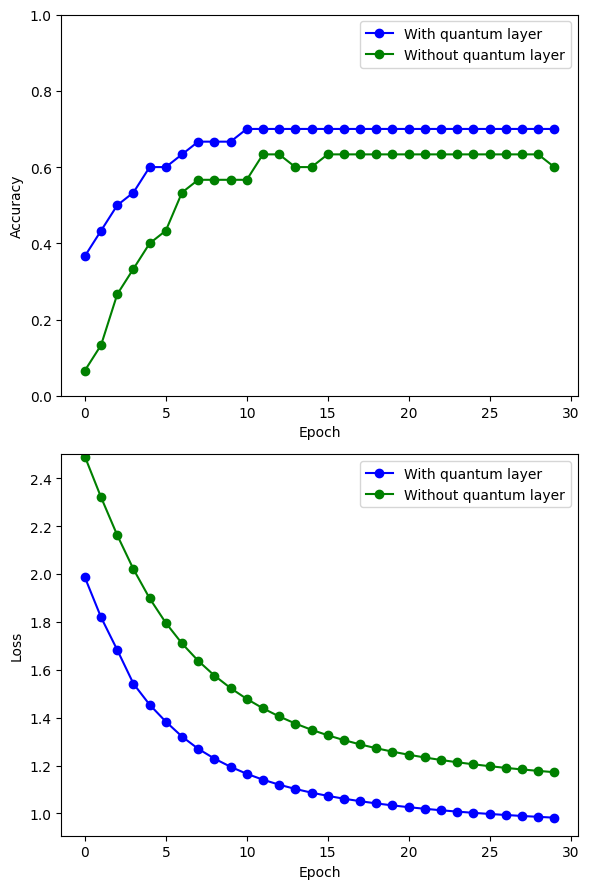

In [47]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


### Conclusion
As we can see above, the quantum circuit based results look better. However, it is somewhat random in nature on how much benefit we see from one run to another.